In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_validate, train_test_split, cross_val_score)
from sklearn.metrics import make_scorer,recall_score
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from scipy.stats import skew, kurtosis

from time import time
import warnings
plt.rc('font', family='NanumGothic')
warnings.filterwarnings('ignore')

# Movie Industry
Netflix 같은 OTT가 떠오르면서 영화 산업이 어떻게 변화하였는가

budget: the budget of a movie. Some movies don't have this, so it appears as 0

company: the production company

country: country of origin

director: the director

genre: main genre of the movie.

gross: revenue of the movie

name: name of the movie

rating: rating of the movie (R, PG, etc.)

released: release date (YYYY-MM-DD)

runtime: duration of the movie

score: IMDb user rating

votes: number of user votes

star: main actor/actress

writer: writer of the movie

year: year of release

In [172]:
df = pd.read_csv('movies.csv')
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [60]:
df.duplicated().value_counts()

False    7668
dtype: int64

In [61]:
df.isna().sum()

name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64

In [62]:
df.loc[df.released.isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5728,Saw: The Final Chapter,R,Crime,2010,NaN,5.6,93000.0,Kevin Greutert,Patrick Melton,Tobin Bell,NaN,NaN,NaN,NaN,NaN
5730,The Wolfman,R,Drama,2010,NaN,5.8,104000.0,Joe Johnston,Andrew Kevin Walker,Benicio Del Toro,NaN,NaN,NaN,NaN,NaN


In [50]:
# df = df.dropna(subset='released')
# df.loc[df.released.isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,released_dt


### rating
관람등급

In [63]:
df.rating.value_counts()

R            3697
PG-13        2112
PG           1252
Not Rated     283
G             153
Unrated        52
NC-17          23
TV-MA           9
TV-PG           5
X               3
Approved        1
TV-14           1
Name: rating, dtype: int64

Text(0.5, 1.0, 'rating')

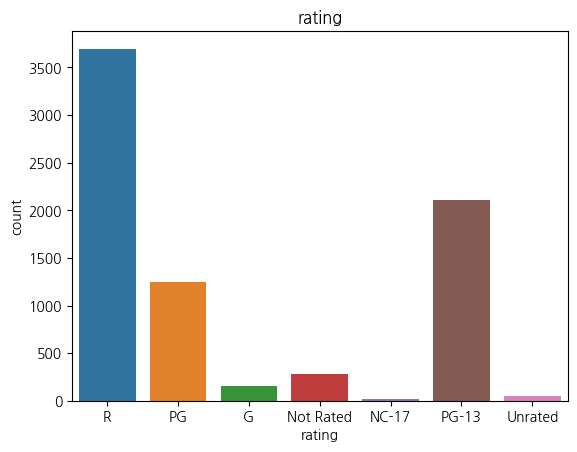

In [64]:
sns.countplot(x='rating', data=df.loc[df.rating.isin(['R', 'PG-13', 'PG', 'Not Rated', 'G', 
                                                      'Unrated', 'NC-17'])])
plt.title('rating')

### genre

In [65]:
df.genre.value_counts()

Comedy       2245
Action       1705
Drama        1518
Crime         551
Biography     443
Adventure     427
Animation     338
Horror        322
Fantasy        44
Mystery        20
Thriller       16
Family         11
Sci-Fi         10
Romance        10
Western         3
Musical         2
Music           1
History         1
Sport           1
Name: genre, dtype: int64

Comedy, Action, Drama 영화가 많이 나옴

Text(0.5, 1.0, 'genre')

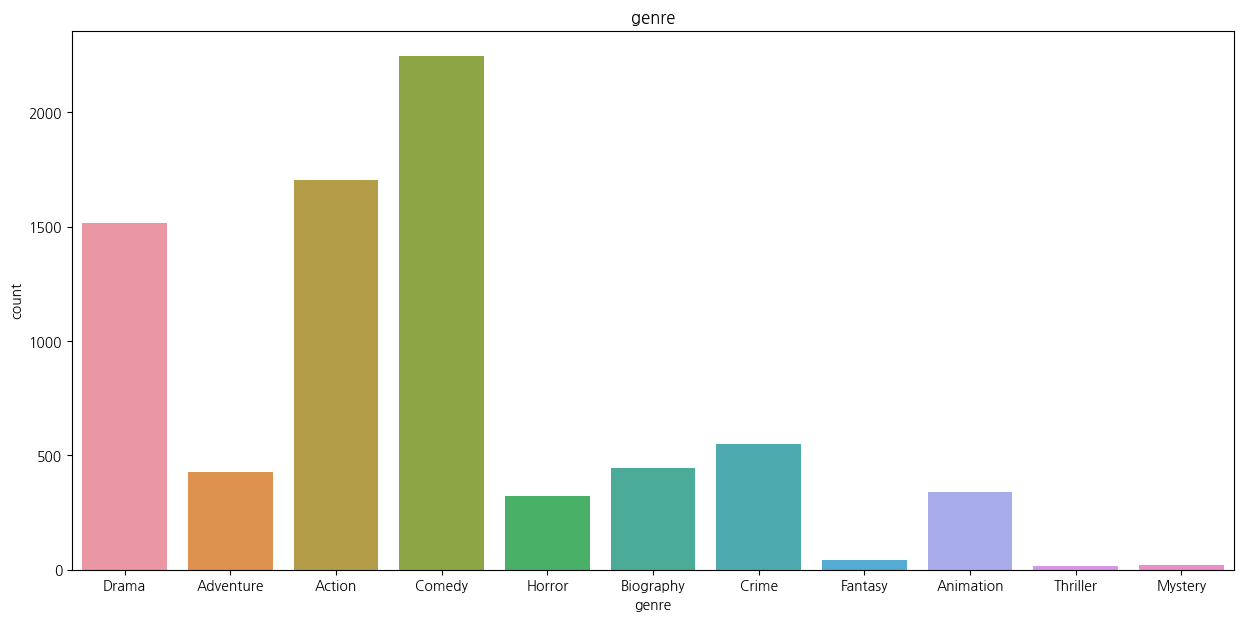

In [66]:
plt.figure(figsize=(15,7))
sns.countplot(x='genre', data=df.loc[df.genre.isin(['Comedy', 'Action', 'Drama', 'Crime', 'Biography',
                                                    'Adventure', 'Animation', 'Horror', 'Fantasy', 'Mystery', 'Thriller'])])
plt.title('genre')

### year

In [67]:
df.year.value_counts()

2000    200
2009    200
2002    200
2003    200
2004    200
2005    200
2006    200
2007    200
2008    200
2010    200
2019    200
2011    200
2012    200
2013    200
2014    200
2015    200
2016    200
2017    200
2001    200
1999    200
1990    200
1991    200
1985    200
1986    200
1987    200
1988    200
1989    200
1998    200
2018    200
1992    200
1993    200
1994    200
1995    200
1996    200
1997    200
1984    168
1983    144
1982    126
1981    113
1980     92
2020     25
Name: year, dtype: int64

Text(0.5, 1.0, 'year')

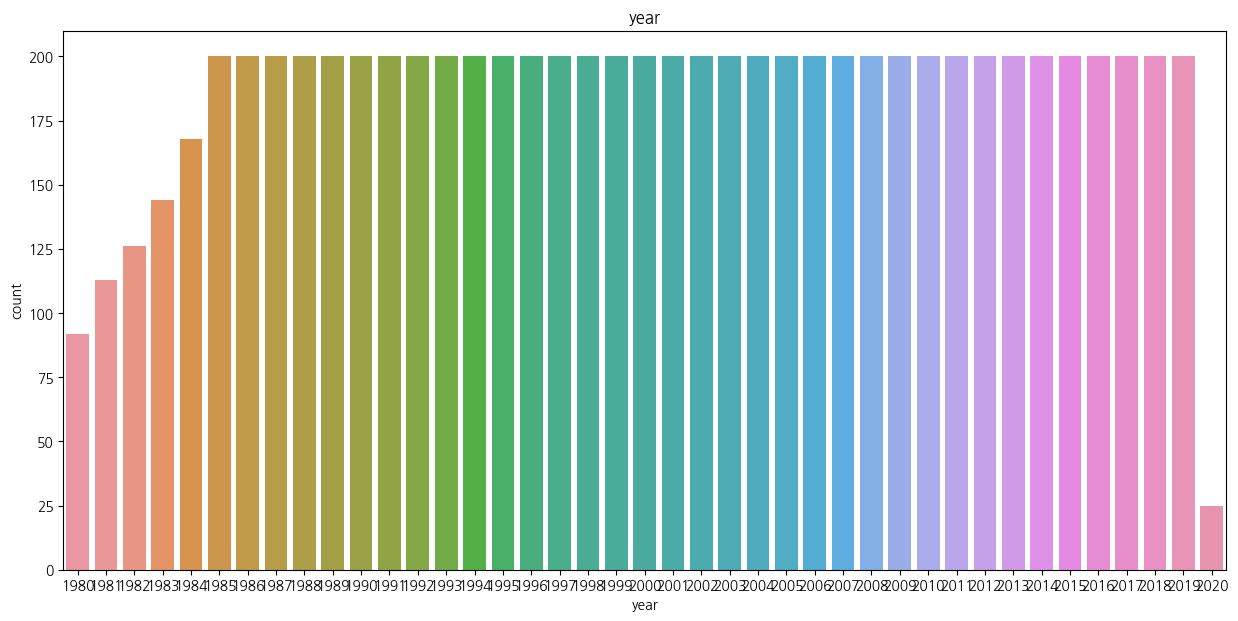

In [68]:
plt.figure(figsize=(15,7))
sns.countplot(x='year', data=df)
plt.title('year')

### released
year 컬럼과 겹침

In [57]:
df.released.value_counts()

February 14, 1986 (United States)    9
May 17, 2019 (United States)         9
October 4, 1991 (United States)      9
August 26, 2016 (United States)      8
October 11, 2002 (United States)     8
                                    ..
March 9, 2000 (Australia)            1
July 20, 2001 (United Kingdom)       1
October 11, 2000 (France)            1
May 10, 2001 (Australia)             1
August 19, 2020 (United States)      1
Name: released, Length: 3414, dtype: int64

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7666 entries, 0 to 7667
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         7666 non-null   object 
 1   rating       7589 non-null   object 
 2   genre        7666 non-null   object 
 3   year         7666 non-null   int64  
 4   released     7666 non-null   object 
 5   score        7663 non-null   float64
 6   votes        7663 non-null   float64
 7   director     7666 non-null   object 
 8   writer       7663 non-null   object 
 9   star         7665 non-null   object 
 10  country      7665 non-null   object 
 11  budget       5497 non-null   float64
 12  gross        7479 non-null   float64
 13  company      7651 non-null   object 
 14  runtime      7664 non-null   float64
 15  released_dt  7666 non-null   object 
dtypes: float64(5), int64(1), object(10)
memory usage: 1018.1+ KB


In [41]:
df.loc[df.released.isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,released_dt
5728,Saw: The Final Chapter,R,Crime,2010,NaN,5.6,93000.0,Kevin Greutert,Patrick Melton,Tobin Bell,NaN,NaN,NaN,NaN,NaN,nan
5730,The Wolfman,R,Drama,2010,NaN,5.8,104000.0,Joe Johnston,Andrew Kevin Walker,Benicio Del Toro,NaN,NaN,NaN,NaN,NaN,nan


In [173]:
df['released_dt'] = [str(d).split('(')[0] for d in df['released']]
df['month'] = [str(d).split()[0] for d in df['released_dt']]
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,released_dt,month
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,"June 13, 1980",June
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,"July 2, 1980",July
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,"June 20, 1980",June
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,"July 2, 1980",July
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,"July 25, 1980",July


Text(0.5, 1.0, 'month')

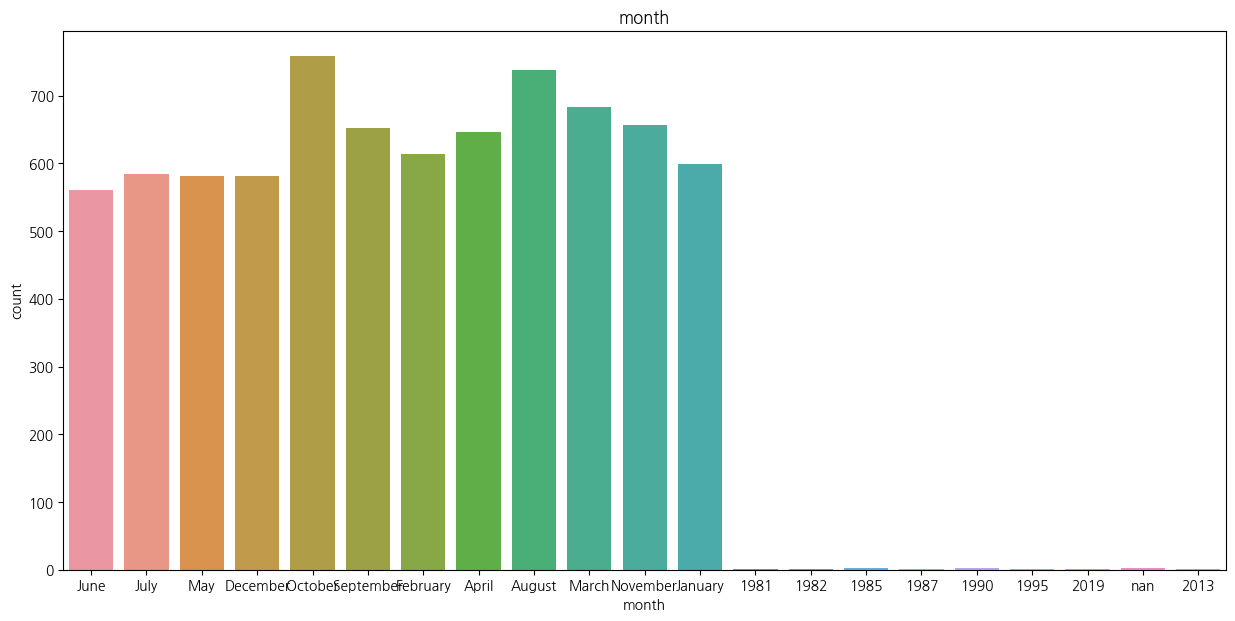

In [174]:
plt.figure(figsize=(15,7))
sns.countplot(x='month', data=df)
plt.title('month')

In [86]:
df.month.unique()

array(['June', 'July', 'May', 'December', 'October', 'September',
       'February', 'April', 'August', 'March', 'November', 'January',
       'nan'], dtype=object)

In [175]:
df.loc[df.month.isin(['1981','1982','1985','1987','1990','1995','2019','2013'])]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,released_dt,month
201,Longshot,TV-PG,Comedy,1981,1981 (United States),5.1,101.0,E.W. Swackhamer,Barry Rosen,Leif Garrett,United States,NaN,NaN,Greentree,100.0,1981,1981
312,Five Days One Summer,PG,Drama,1982,1982 (Japan),6.1,1000.0,Fred Zinnemann,Michael Austin,Sean Connery,United States,15000000.0,199078.0,Cable and Wireless Finance,108.0,1982,1982
786,Taipei Story,Not Rated,Drama,1985,1985 (Taiwan),7.7,2500.0,Edward Yang,T'ien-wen Chu,Chin Tsai,Taiwan,NaN,35336.0,Evergreen Film Company,119.0,1985,1985
800,O.C. and Stiggs,R,Comedy,1985,1985 (United States),5.4,1200.0,Robert Altman,Tod Carroll,Daniel Jenkins,United States,7000000.0,29815.0,Metro-Goldwyn-Mayer (MGM),109.0,1985,1985
1173,The House on Carroll Street,PG,Thriller,1987,1987 (United States),6.1,2300.0,Peter Yates,Walter Bernstein,Kelly McGillis,United States,14000000.0,459824.0,Orion Pictures,101.0,1987,1987
1820,The Garden,Unrated,Drama,1990,1990 (United States),6.4,840.0,Derek Jarman,NaN,Tilda Swinton,United Kingdom,NaN,5006.0,Basilisk Communications,92.0,1990,1990
1825,Strangers in Good Company,PG,Drama,1990,1990 (Canada),7.7,995.0,Cynthia Scott,Gloria Demers,Alice Diabo,Canada,NaN,NaN,National Film Board of Canada (NFB),101.0,1990,1990
2816,The White Balloon,Unrated,Drama,1995,1995 (Iran),7.7,6900.0,Jafar Panahi,Abbas Kiarostami,Aida Mohammadkhani,Iran,150000.0,924940.0,Farabi Cinema Foundation,85.0,1995,1995
4187,Dahmer,R,Biography,2002,2019 (United States),5.6,9700.0,David Jacobson,David Birke,Jeremy Renner,United States,250000.0,144008.0,Blockbuster Films,101.0,2019,2019
6413,Romeo and Juliet,PG-13,Drama,2013,2013 (United States),5.8,11000.0,Carlo Carlei,Arthur Brooke,Hailee Steinfeld,United Kingdom,NaN,2966268.0,Amber Entertainment,118.0,2013,2013


In [80]:
df.loc[df.name=='Longshot', 'month'] = 'July'
df.loc[df.name=='Five Days One Summer', 'month'] = 'November'
df.loc[df.name=='O.C. and Stiggs', 'month'] = 'July'
df.loc[df.name=='Taipei Story', 'month'] = 'April'
df.loc[df.name=='The House on Carroll Street', 'month'] = 'March'
df.loc[df.name=='The Garden', 'month'] = 'September'
df.loc[df.name=='Strangers in Good Company', 'month'] = 'October'
df.loc[df.name=='The White Balloon', 'month'] = 'June'
df.loc[df.name=='Dahmer', 'month'] = 'June'
df.loc[df.name=='Romeo and Juliet', 'month'] = 'October'

Text(0.5, 1.0, 'month')

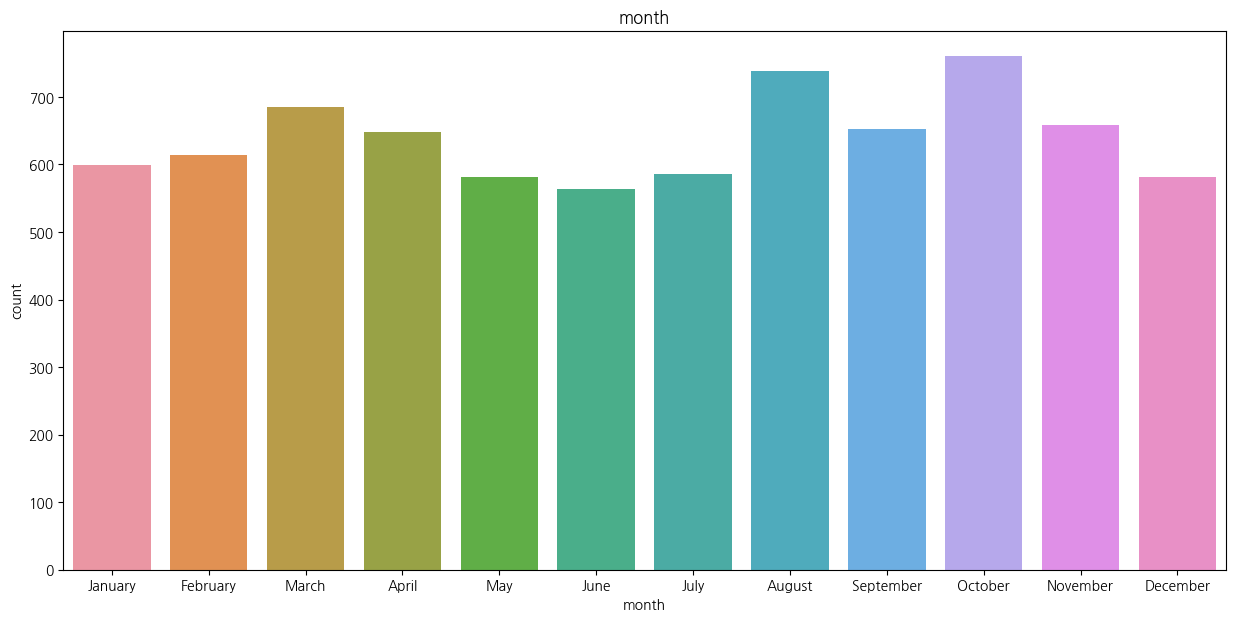

In [89]:
plt.figure(figsize=(15,7))
sns.countplot(x='month', data=df, order=['January','February','March','April','May','June',
                                        'July','August','September','October','November','December'])
plt.title('month')

연도별

Text(0.5, 1.0, 'month_2010s')

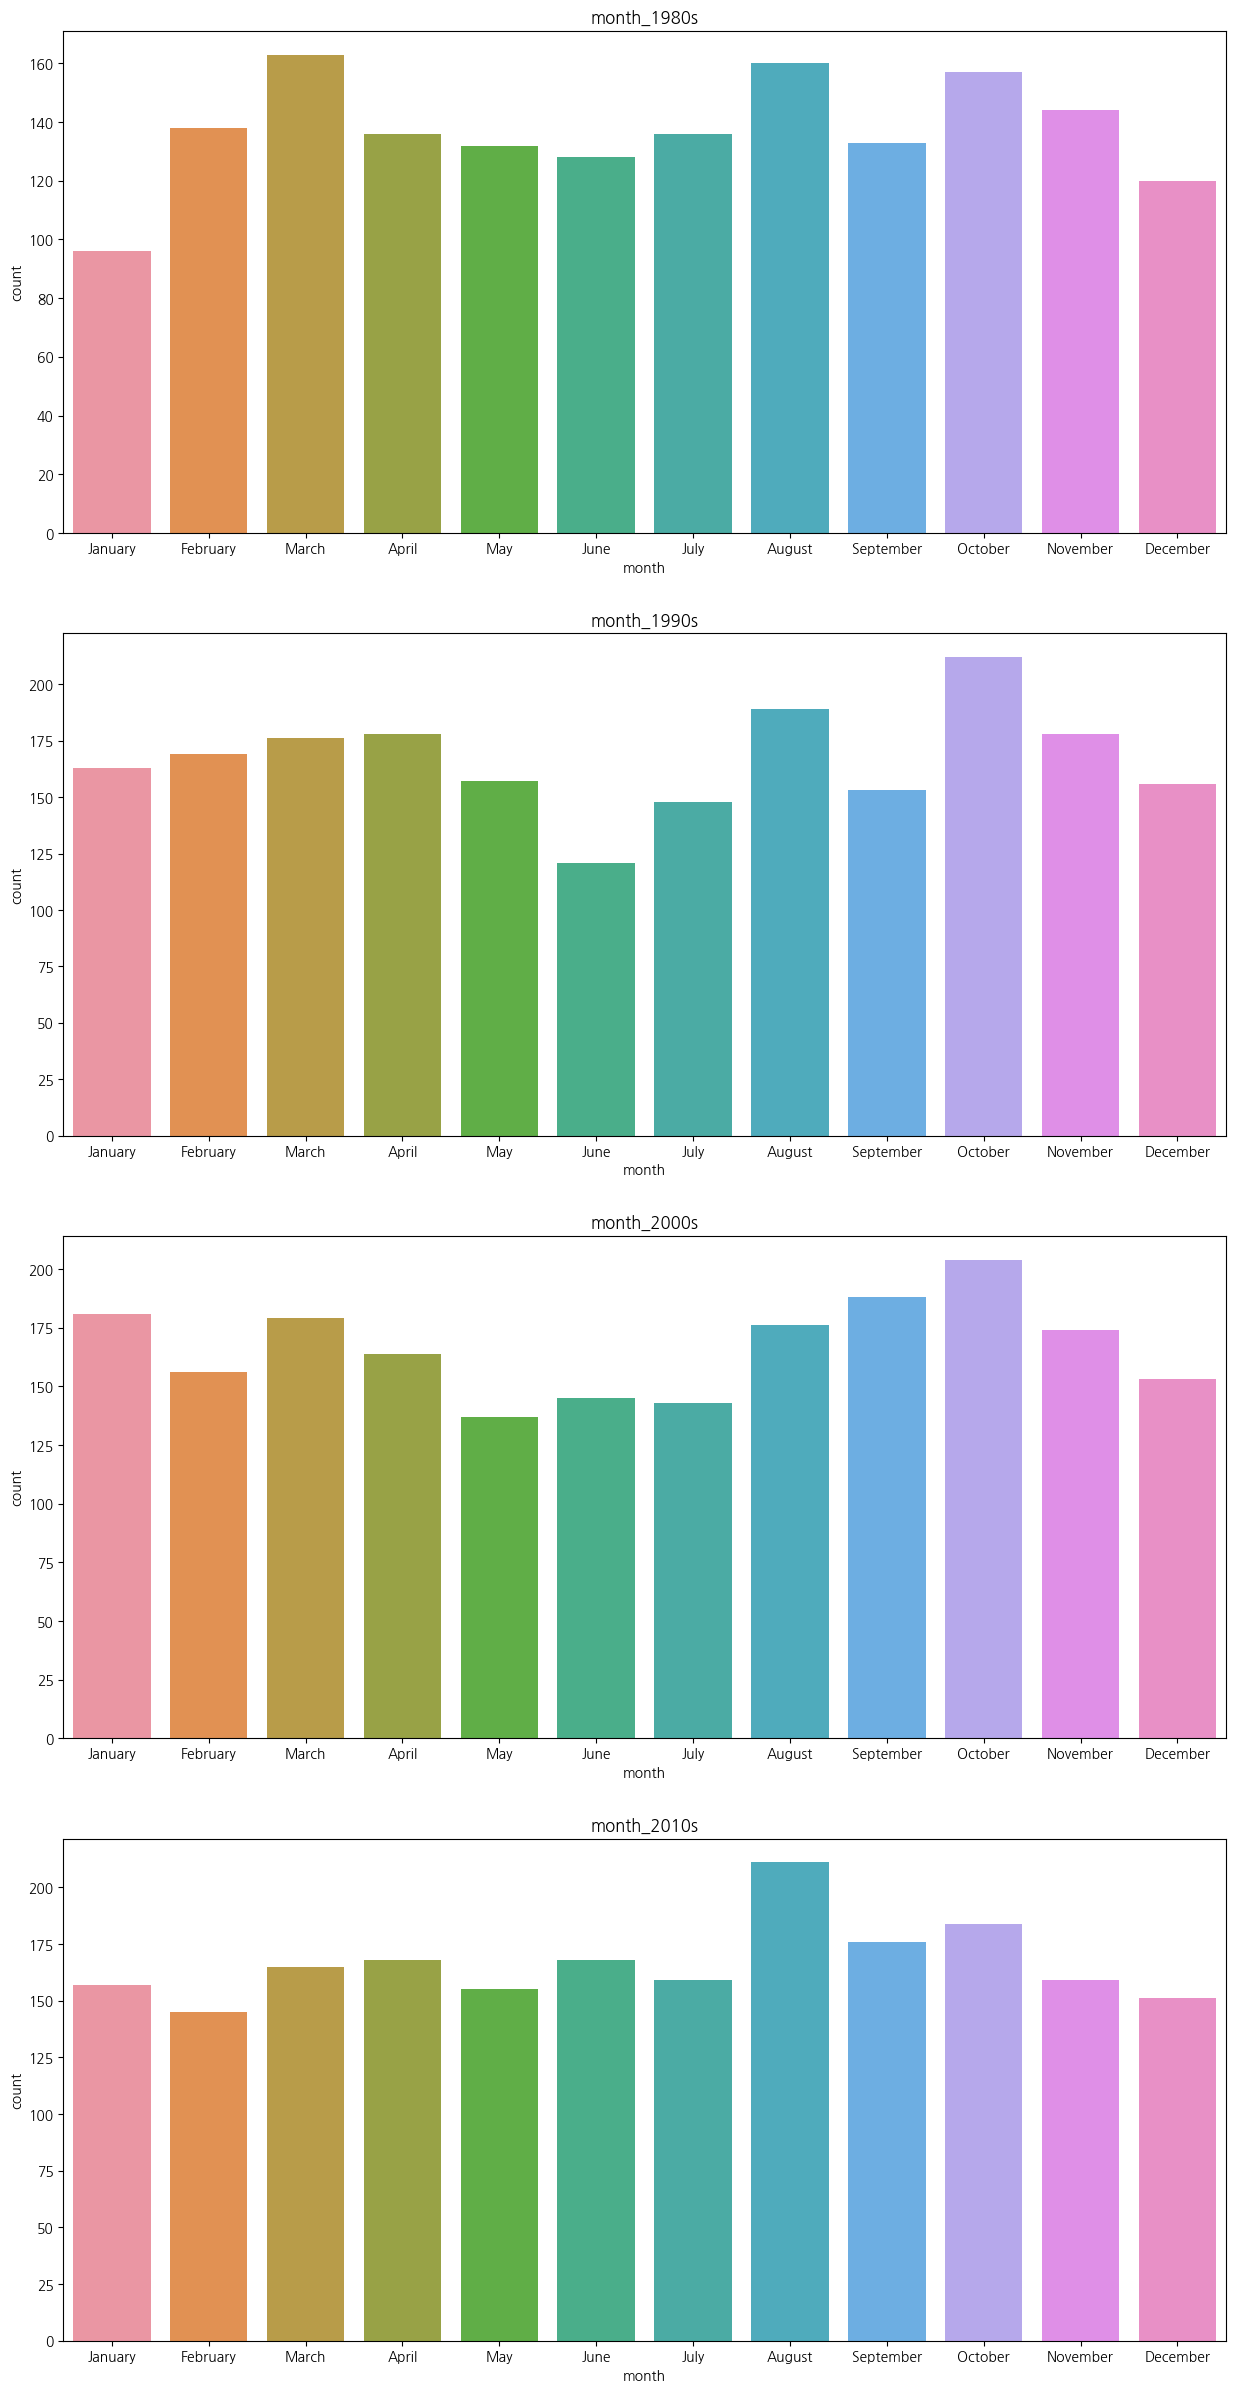

In [127]:
plt.figure(figsize=(15,30))
plt.subplot(4,1,1)
sns.countplot(x='month', data=df.loc[df.year.isin([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989])], 
              order=['January','February','March','April','May','June','July','August','September','October','November','December'])
plt.title('month_1980s')

plt.subplot(4,1,2)
sns.countplot(x='month', data=df.loc[df.year.isin([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])], 
              order=['January','February','March','April','May','June','July','August','September','October','November','December'])
plt.title('month_1990s')

plt.subplot(4,1,3)
sns.countplot(x='month', data=df.loc[df.year.isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009])], 
              order=['January','February','March','April','May','June','July','August','September','October','November','December'])
plt.title('month_2000s')

plt.subplot(4,1,4)
sns.countplot(x='month', data=df.loc[df.year.isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])], 
              order=['January','February','March','April','May','June','July','August','September','October','November','December'])
plt.title('month_2010s')

### score

In [111]:
df.score.value_counts()

6.6    359
6.4    351
6.2    346
6.7    332
6.5    331
      ... 
2.8      2
9.3      1
2.6      1
2.3      1
9.0      1
Name: score, Length: 72, dtype: int64

Text(0.5, 1.0, 'score')

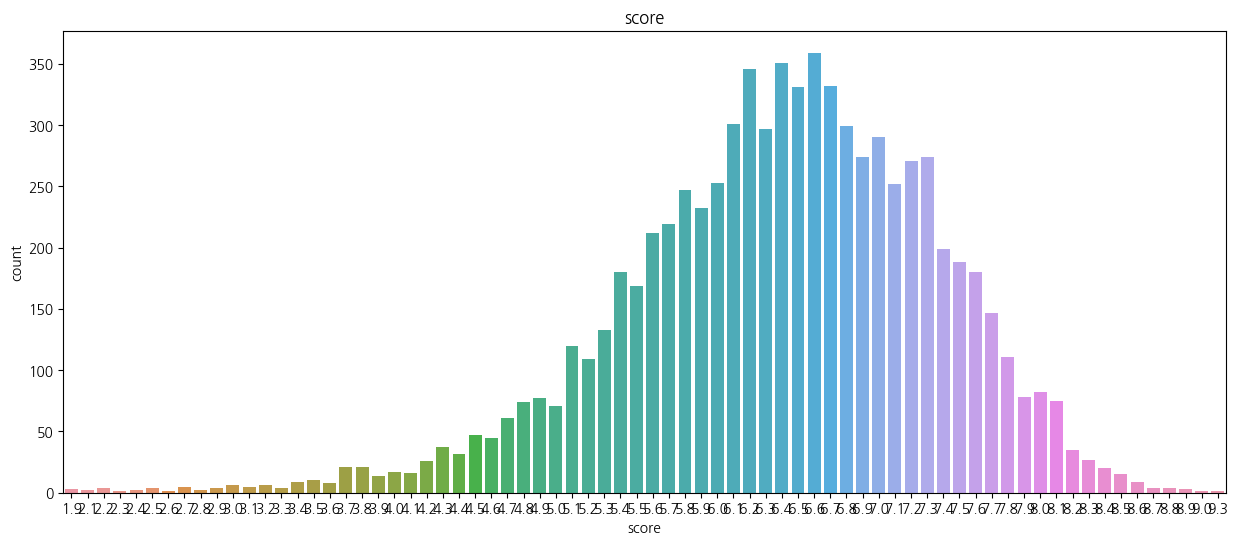

In [115]:
plt.figure(figsize=(15,6))
sns.countplot(x='score', data=df)
plt.title('score')

### votes

In [116]:
df.votes.value_counts()

13000.0     117
11000.0     116
14000.0     105
19000.0     102
15000.0     102
           ... 
270000.0      1
810000.0      1
639.0         1
390.0         1
7.0           1
Name: votes, Length: 936, dtype: int64

Text(0.5, 1.0, 'month_2010s')

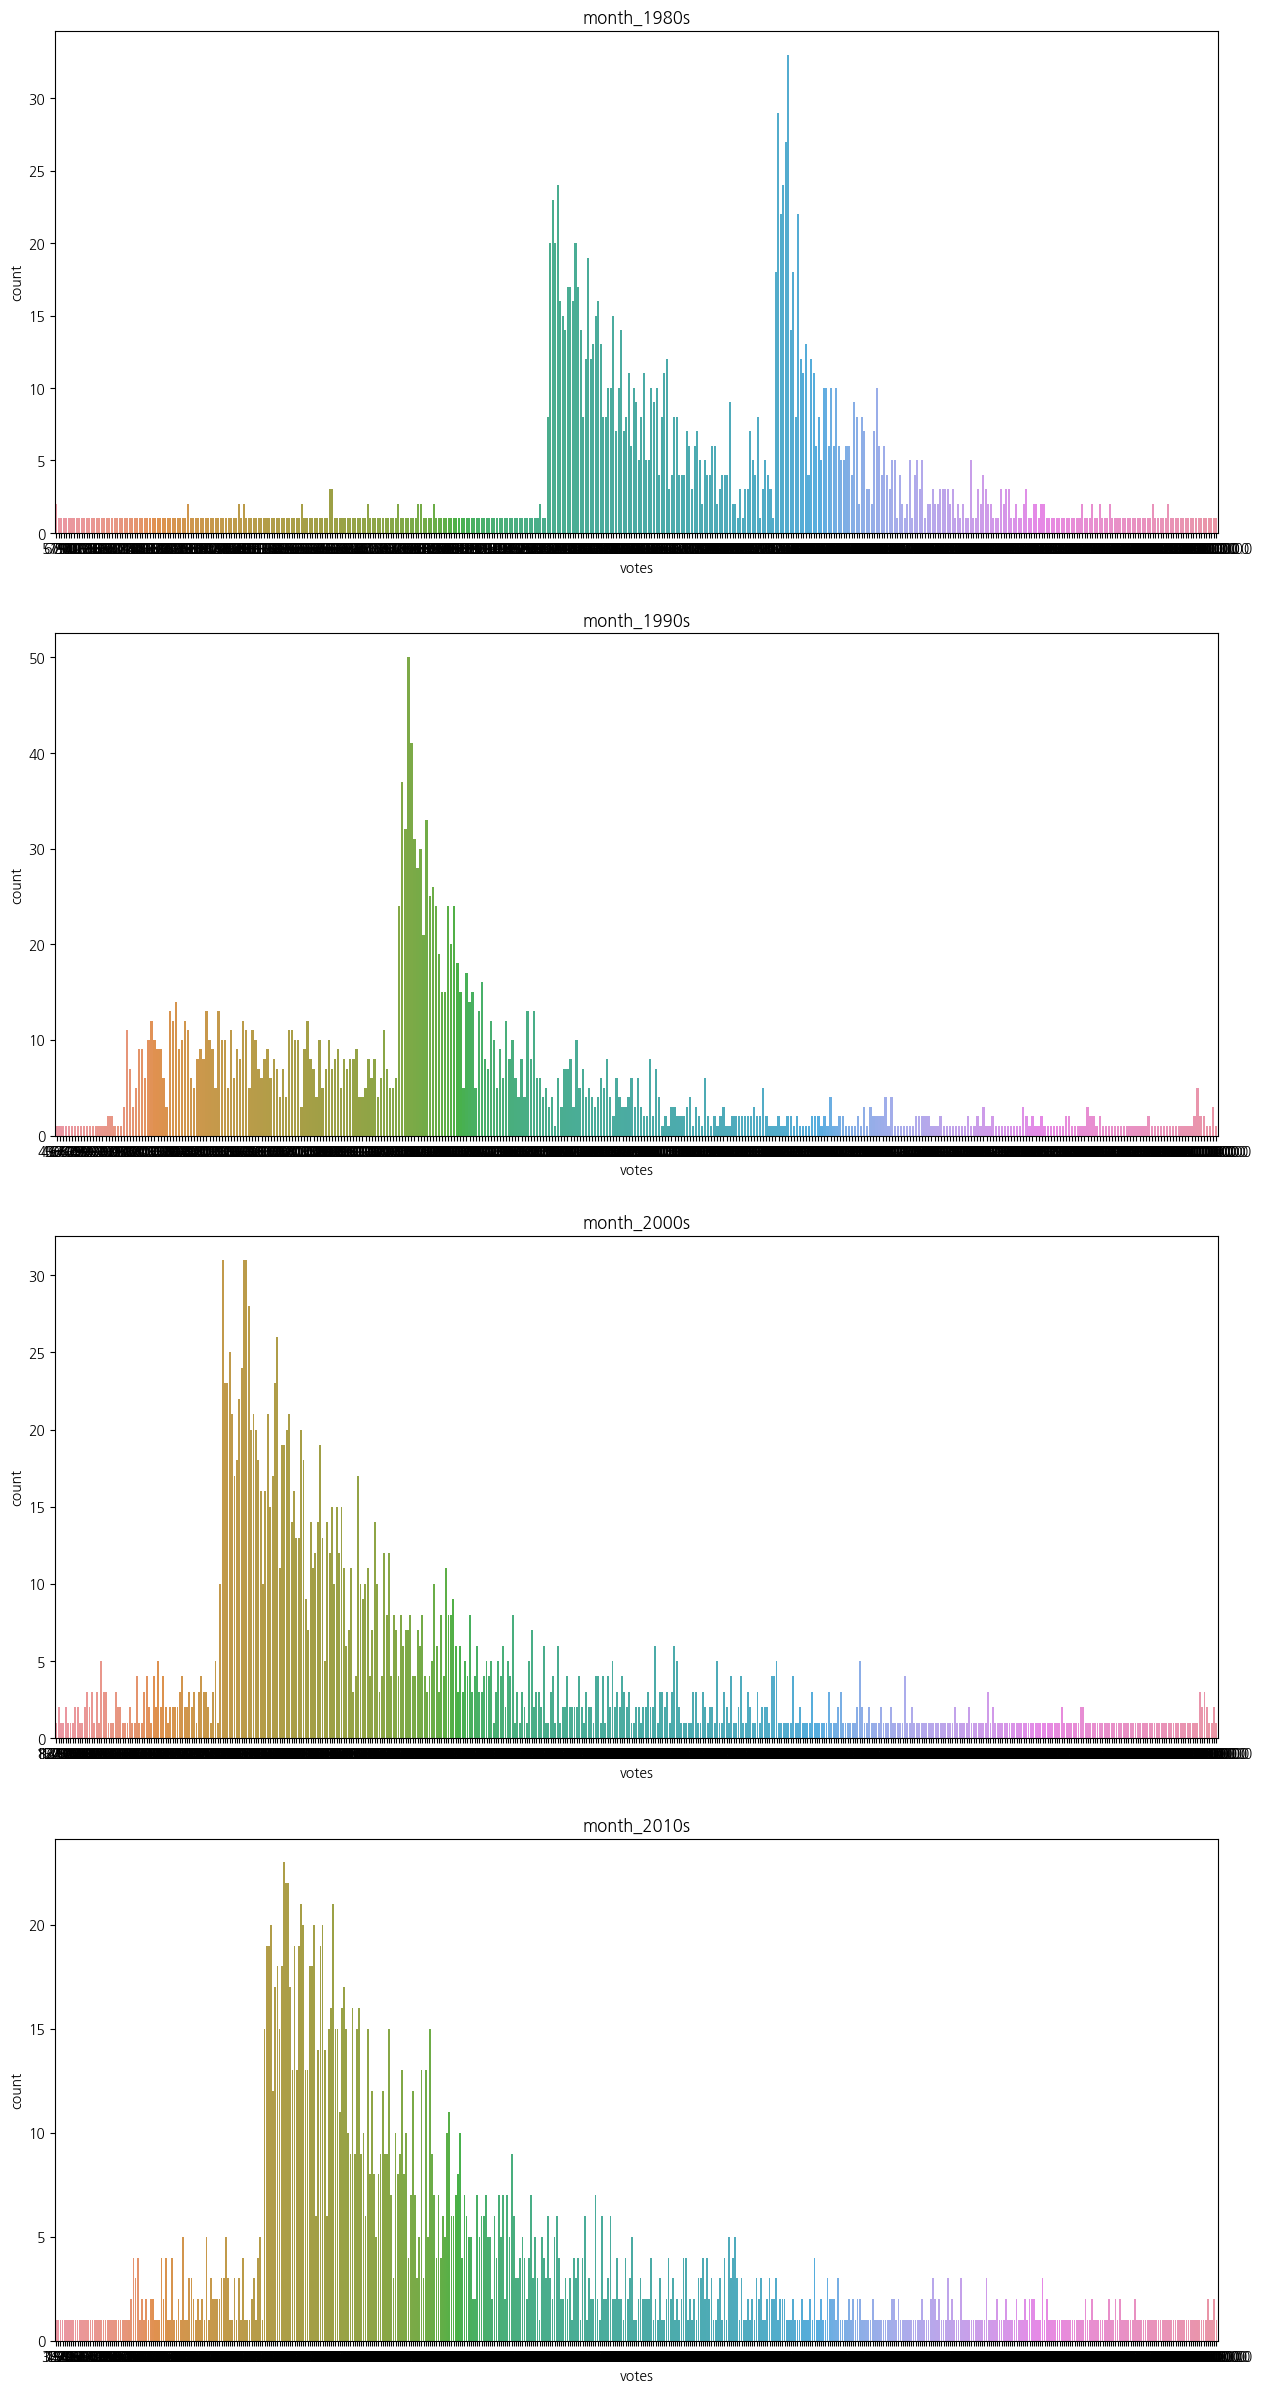

In [130]:
plt.figure(figsize=(15,30))
plt.subplot(4,1,1)
sns.countplot(x='votes', data=df.loc[df.year.isin([1980, 1981, 1982, 1983, 1984, 
                                                   1985, 1986, 1987, 1988, 1989])])
plt.title('month_1980s')

plt.subplot(4,1,2)
sns.countplot(x='votes', data=df.loc[df.year.isin([1990, 1991, 1992, 1993, 1994, 
                                                   1995, 1996, 1997, 1998, 1999])])
plt.title('month_1990s')

plt.subplot(4,1,3)
sns.countplot(x='votes', data=df.loc[df.year.isin([2000, 2001, 2002, 2003, 2004, 
                                                   2005, 2006, 2007, 2008, 2009])])
plt.title('month_2000s')

plt.subplot(4,1,4)
sns.countplot(x='votes', data=df.loc[df.year.isin([2010, 2011, 2012, 2013, 2014, 
                                                   2015, 2016, 2017, 2018, 2019])])
plt.title('month_2010s')

### company

In [203]:
df.company.value_counts()

Universal Pictures          377
Warner Bros.                334
Columbia Pictures           332
Paramount Pictures          320
Twentieth Century Fox       240
                           ... 
Digital Image Associates      1
Kopelson Entertainment        1
Clavius Base                  1
Tim Burton Productions        1
PK 65 Films                   1
Name: company, Length: 2385, dtype: int64

In [242]:
top_company = df.company.value_counts().head(10).index
bottom_company = df.company.value_counts().sort_values().index[:10]
df_top = df.loc[df.company.isin(top_company)]
df_bottom = df.loc[df.company.isin(bottom_company)]
bottom_company

Index(['Sikhya Entertainment', 'Geechee Girls', 'Initial Films',
       'C.L.G. Films', 'House & Moorhouse Films', 'Marble Hall', 'Krisjair',
       'Esperanto Filmoj', 'Les Films 21', 'A.M.A. Film'],
      dtype='object')

In [275]:
print(len(df_top), len(df))
print('대형제작사 영화 비율:', len(df_top)/len(df))

2251 7668
대형제작사 영화 비율: 0.29355764214919144


In [273]:
df_top.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,released_dt,month
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,"June 13, 1980",June
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,"July 2, 1980",July
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,"July 2, 1980",July
5,Friday the 13th,R,Horror,1980,"May 9, 1980 (United States)",6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,39754601.0,Paramount Pictures,95.0,"May 9, 1980",May
6,The Blues Brothers,R,Action,1980,"June 20, 1980 (United States)",7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,27000000.0,115229890.0,Universal Pictures,133.0,"June 20, 1980",June


대형제작사가 만든 영화의 평점이 좋을까?

In [246]:
df.company.value_counts().sort_values()

Sikhya Entertainment         1
Geechee Girls                1
Initial Films                1
C.L.G. Films                 1
House & Moorhouse Films      1
                          ... 
Twentieth Century Fox      240
Paramount Pictures         320
Columbia Pictures          332
Warner Bros.               334
Universal Pictures         377
Name: company, Length: 2385, dtype: int64

skew_top: -0.4585777204825981 / skew_bottom: nan


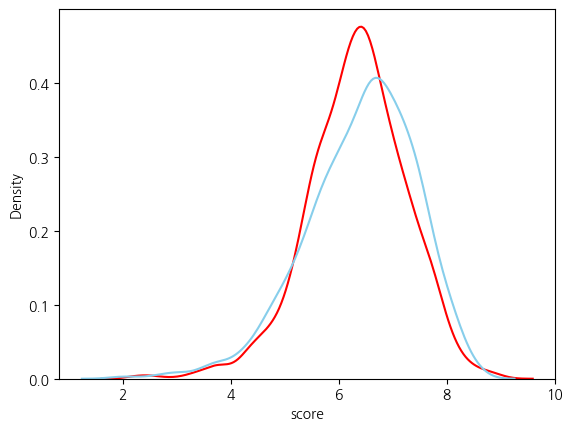

In [271]:
bottom_company = df.company.value_counts().sort_values().index[:2000]
df_bottom = df.loc[df.company.isin(bottom_company)]

sns.kdeplot(x='score', data=df_top, color='red')
sns.kdeplot(x='score', data=df_bottom, color='skyblue')
print('skew_top:', skew(df_top.score), '/ skew_bottom:', skew(df_bottom.score))

skew_top: -0.4585777204825981 / skew_bottom: -0.6834877075106803


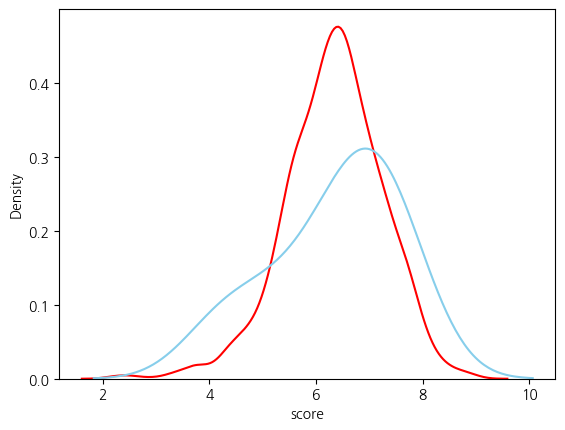

In [261]:
bottom_company = df.company.value_counts().sort_values().index[:10]
df_bottom = df.loc[df.company.isin(bottom_company)]

sns.kdeplot(x='score', data=df_top, color='red')
sns.kdeplot(x='score', data=df_bottom, color='skyblue')
print('skew_top:', skew(df_top.score), '/ skew_bottom:', skew(df_bottom.score))

skew_top: -0.4585777204825981 / skew_bottom: -0.7580691650193031


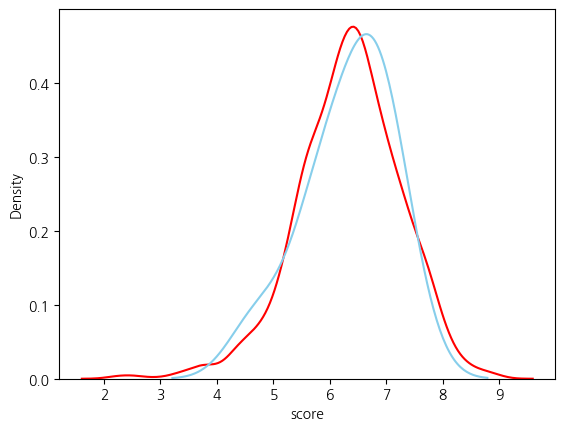

In [262]:
bottom_company = df.company.value_counts().sort_values().index[10:20]
df_bottom = df.loc[df.company.isin(bottom_company)]

sns.kdeplot(x='score', data=df_top, color='red')
sns.kdeplot(x='score', data=df_bottom, color='skyblue')
print('skew_top:', skew(df_top.score), '/ skew_bottom:', skew(df_bottom.score))

skew_top: -0.4585777204825981 / skew_bottom: -0.4703159498894478


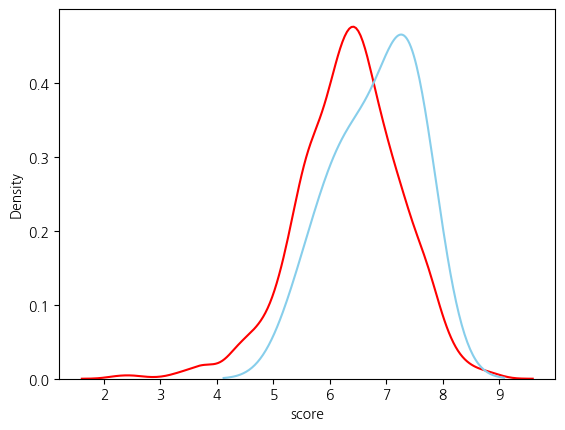

In [263]:
bottom_company = df.company.value_counts().sort_values().index[20:30]
df_bottom = df.loc[df.company.isin(bottom_company)]

sns.kdeplot(x='score', data=df_top, color='red')
sns.kdeplot(x='score', data=df_bottom, color='skyblue')
print('skew_top:', skew(df_top.score), '/ skew_bottom:', skew(df_bottom.score))

skew_top: -0.4585777204825981 / skew_bottom: -0.6932110602320699


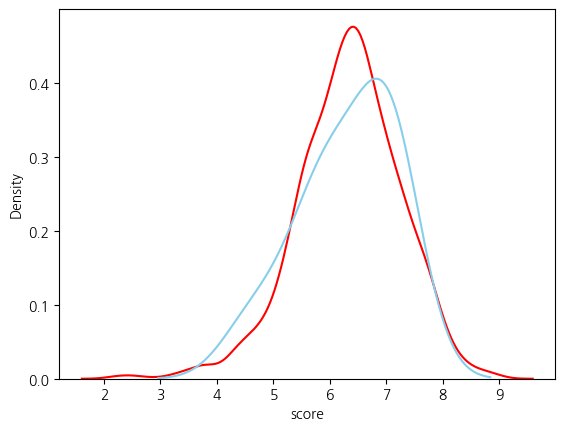

In [264]:
bottom_company = df.company.value_counts().sort_values().index[30:40]
df_bottom = df.loc[df.company.isin(bottom_company)]

sns.kdeplot(x='score', data=df_top, color='red')
sns.kdeplot(x='score', data=df_bottom, color='skyblue')
print('skew_top:', skew(df_top.score), '/ skew_bottom:', skew(df_bottom.score))

skew_top: nan / skew_bottom: nan


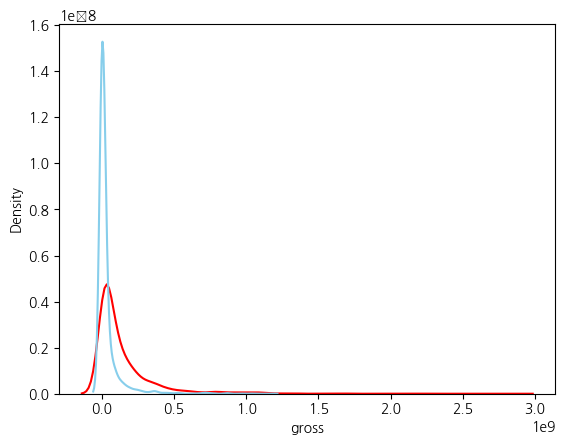

In [277]:
top_company = df.company.value_counts().head(10).index
bottom_company = df.company.value_counts().sort_values().index[:2000]
df_top = df.loc[df.company.isin(top_company)]
df_bottom = df.loc[df.company.isin(bottom_company)]

sns.kdeplot(x='gross', data=df_top, color='red')
sns.kdeplot(x='gross', data=df_bottom, color='skyblue')
print('skew_top:', skew(df_top.gross), '/ skew_bottom:', skew(df_bottom.gross))

skew_top: nan / skew_bottom: nan


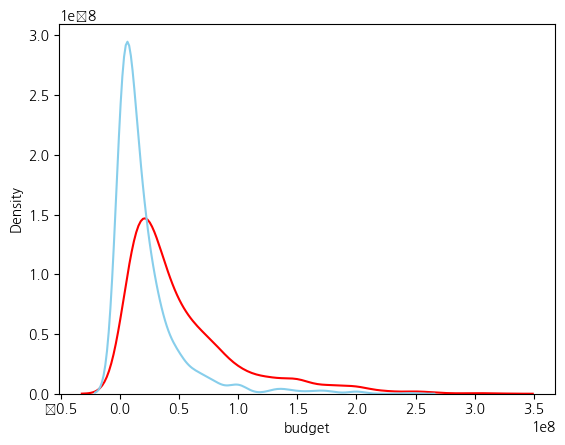

In [278]:
top_company = df.company.value_counts().head(10).index
bottom_company = df.company.value_counts().sort_values().index[:2000]
df_top = df.loc[df.company.isin(top_company)]
df_bottom = df.loc[df.company.isin(bottom_company)]

sns.kdeplot(x='budget', data=df_top, color='red')
sns.kdeplot(x='budget', data=df_bottom, color='skyblue')
print('skew_top:', skew(df_top.budget), '/ skew_bottom:', skew(df_bottom.budget))

In [281]:
df['예산 대비 수익율'] = df['gross'] / df['budget']
df['수익-예산'] = df['gross'] - df['budget']
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,released_dt,month,예산 대비 수익율,수익-예산
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,"June 13, 1980",June,2.473620,27998772.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,"July 2, 1980",July,13.078468,54353106.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,"June 20, 1980",June,29.909726,520375067.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,"July 2, 1980",July,23.843868,79953539.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,"July 25, 1980",July,6.641057,33846344.0


<AxesSubplot:xlabel='예산 대비 수익율', ylabel='Density'>

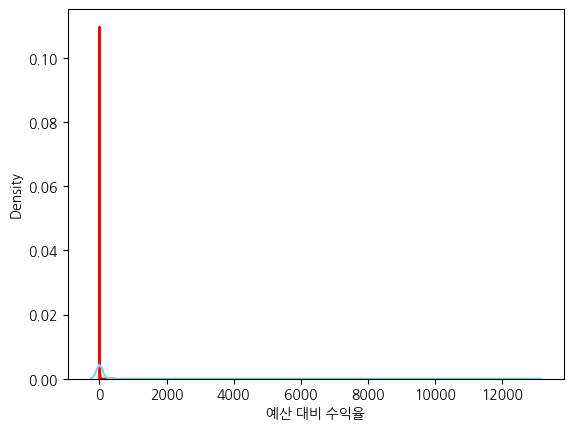

In [282]:
top_company = df.company.value_counts().head(10).index
bottom_company = df.company.value_counts().sort_values().index[:2000]
df_top = df.loc[df.company.isin(top_company)]
df_bottom = df.loc[df.company.isin(bottom_company)]

sns.kdeplot(x='예산 대비 수익율', data=df_top, color='red')
sns.kdeplot(x='예산 대비 수익율', data=df_bottom, color='skyblue')
# print('skew_top:', skew(df_top.budget), '/ skew_bottom:', skew(df_bottom.budget))

<AxesSubplot:xlabel='수익-예산', ylabel='Density'>

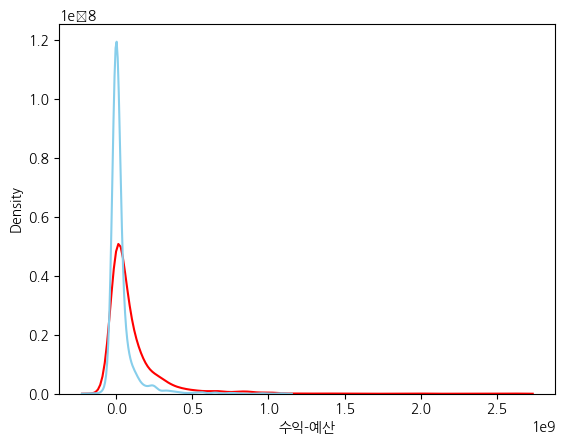

In [283]:
top_company = df.company.value_counts().head(10).index
bottom_company = df.company.value_counts().sort_values().index[:2000]
df_top = df.loc[df.company.isin(top_company)]
df_bottom = df.loc[df.company.isin(bottom_company)]

sns.kdeplot(x='수익-예산', data=df_top, color='red')
sns.kdeplot(x='수익-예산', data=df_bottom, color='skyblue')
# print('skew_top:', skew(df_top.budget), '/ skew_bottom:', skew(df_bottom.budget))

### director

In [141]:
df.director.value_counts()

Woody Allen         38
Clint Eastwood      31
Directors           28
Steven Spielberg    27
Ron Howard          24
                    ..
Marcelo Epstein      1
Thomas Rickman       1
Paolo Taviani        1
Lawrence Dane        1
Pereko Mosia         1
Name: director, Length: 2949, dtype: int64

### writer

In [140]:
df.writer.value_counts()

Woody Allen            37
Stephen King           31
Luc Besson             26
John Hughes            25
William Shakespeare    15
                       ..
Daniel G. Sullivan      1
Bonnie Turner           1
Dick King-Smith         1
Helen Prejean           1
Pereko Mosia            1
Name: writer, Length: 4535, dtype: int64

### star

In [133]:
df.star.value_counts()[:20]

Nicolas Cage             43
Robert De Niro           41
Tom Hanks                41
Denzel Washington        37
Bruce Willis             34
Tom Cruise               34
Johnny Depp              33
Sylvester Stallone       32
John Travolta            31
Mel Gibson               29
Steve Martin             29
Kevin Costner            29
Adam Sandler             28
Ben Stiller              27
Jeff Bridges             27
Keanu Reeves             27
Robin Williams           27
Arnold Schwarzenegger    27
Eddie Murphy             27
Harrison Ford            26
Name: star, dtype: int64

### country

In [136]:
df.country.value_counts()[:10]

United States     5475
United Kingdom     816
France             279
Canada             190
Germany            117
Australia           92
Japan               81
India               62
Italy               61
Spain               47
Name: country, dtype: int64

### budget

Text(0.5, 1.0, 'budget')

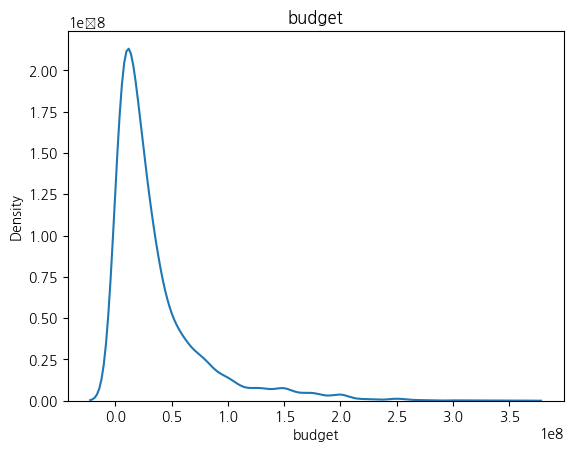

In [137]:
sns.kdeplot(x='budget', data=df)
plt.title('budget')

### gross

Text(0.5, 1.0, 'gross')

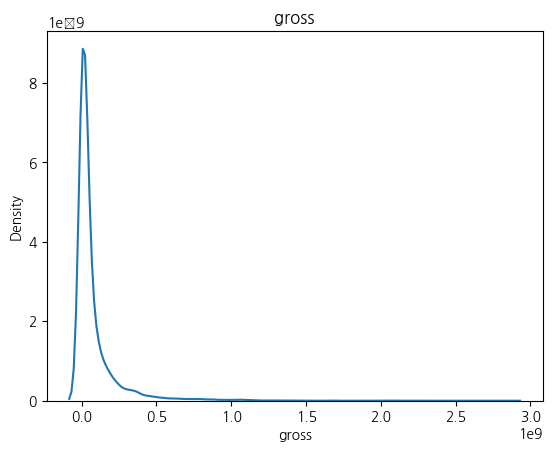

In [138]:
sns.kdeplot(x='gross', data=df)
plt.title('gross')

# ?

### top gross

Titanic을 제외하고는 모두 2000년 이후 영화

In [148]:
df.sort_values('gross', ascending=False).head(10)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,released_dt,month
5445,Avatar,PG-13,Action,2009,"December 18, 2009 (United States)",7.8,1100000.0,James Cameron,James Cameron,Sam Worthington,United States,237000000.0,2.847246e+09,Twentieth Century Fox,162.0,"December 18, 2009",December
7445,Avengers: Endgame,PG-13,Action,2019,"April 26, 2019 (United States)",8.4,903000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000.0,2.797501e+09,Marvel Studios,181.0,"April 26, 2019",April
3045,Titanic,PG-13,Drama,1997,"December 19, 1997 (United States)",7.8,1100000.0,James Cameron,James Cameron,Leonardo DiCaprio,United States,200000000.0,2.201647e+09,Twentieth Century Fox,194.0,"December 19, 1997",December
6663,Star Wars: Episode VII - The Force Awakens,PG-13,Action,2015,"December 18, 2015 (United States)",7.8,876000.0,J.J. Abrams,Lawrence Kasdan,Daisy Ridley,United States,245000000.0,2.069522e+09,Lucasfilm,138.0,"December 18, 2015",December
7244,Avengers: Infinity War,PG-13,Action,2018,"April 27, 2018 (United States)",8.4,897000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,321000000.0,2.048360e+09,Marvel Studios,149.0,"April 27, 2018",April
7480,The Lion King,PG,Animation,2019,"July 19, 2019 (United States)",6.9,222000.0,Jon Favreau,Jeff Nathanson,Donald Glover,United States,260000000.0,1.670728e+09,Walt Disney Pictures,118.0,"July 19, 2019",July
6653,Jurassic World,PG-13,Action,2015,"June 12, 2015 (United States)",7.0,593000.0,Colin Trevorrow,Rick Jaffa,Chris Pratt,United States,150000000.0,1.670516e+09,Universal Pictures,124.0,"June 12, 2015",June
6043,The Avengers,PG-13,Action,2012,"May 4, 2012 (United States)",8.0,1300000.0,Joss Whedon,Joss Whedon,Robert Downey Jr.,United States,220000000.0,1.518816e+09,Marvel Studios,143.0,"May 4, 2012",May
6646,Furious 7,PG-13,Action,2015,"April 3, 2015 (United States)",7.1,370000.0,James Wan,Chris Morgan,Vin Diesel,United States,190000000.0,1.515341e+09,Universal Pictures,137.0,"April 3, 2015",April
7494,Frozen II,PG,Animation,2019,"November 22, 2019 (United States)",6.8,148000.0,Chris Buck,Jennifer Lee,Kristen Bell,United States,150000000.0,1.450027e+09,Walt Disney Animation Studios,103.0,"November 22, 2019",November


영화산업을 디즈니가 잡아먹고 있다  
대형제작사가 아닌 중소제작사의 영화 수익, 예산은 어떨까? (-> 영화 산업에 대한 이해가 필요한 부분)

<AxesSubplot:xlabel='name', ylabel='gross'>

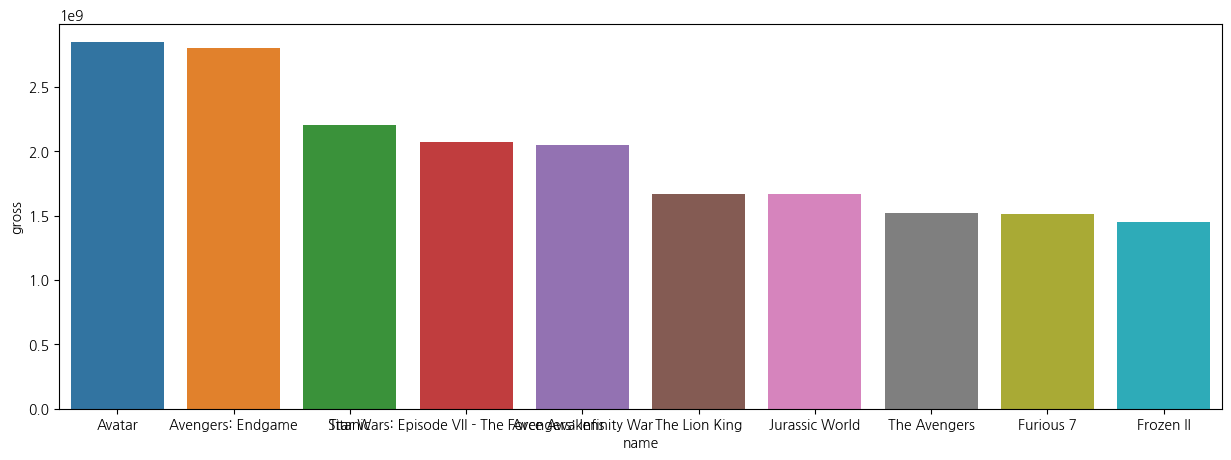

In [151]:
plt.figure(figsize=(15,5))
sns.barplot(x='name', y='gross', data=df.sort_values('gross', ascending=False).head(10))

<AxesSubplot:xlabel='name', ylabel='gross'>

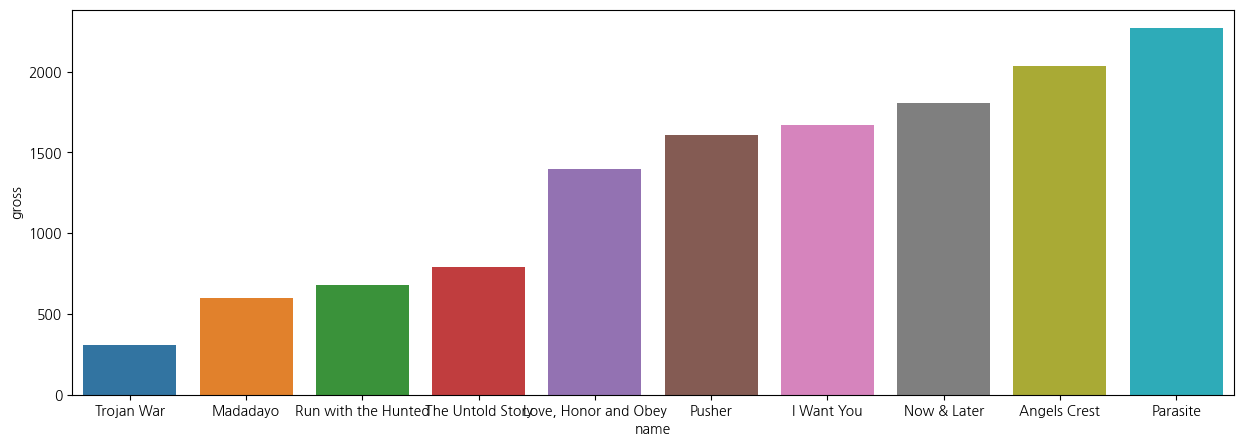

In [177]:
plt.figure(figsize=(15,5))
sns.barplot(x='name', y='gross', data=df.sort_values('gross').head(10))

<AxesSubplot:xlabel='name', ylabel='budget'>

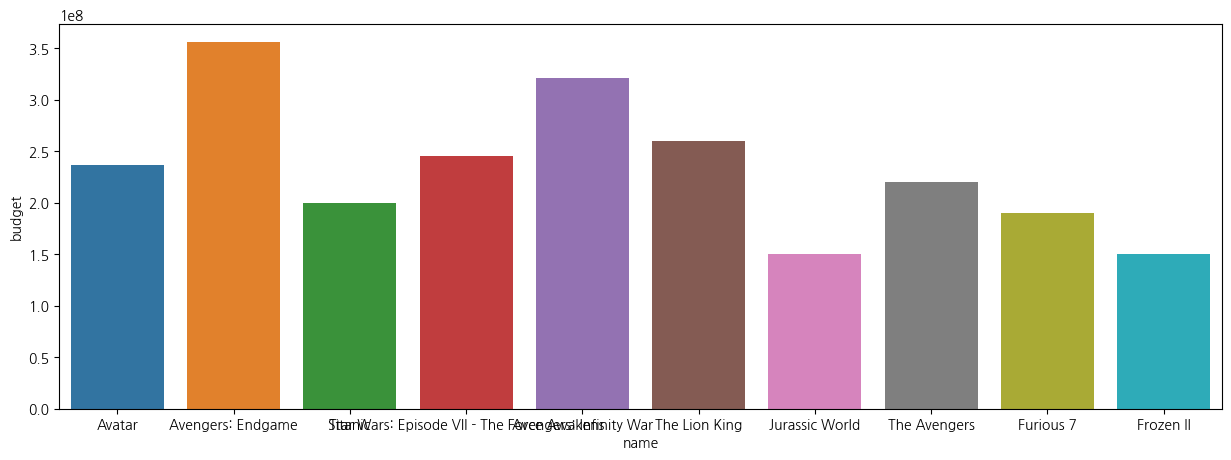

In [152]:
plt.figure(figsize=(15,5))
sns.barplot(x='name', y='budget', data=df.sort_values('gross', ascending=False).head(10))

<AxesSubplot:xlabel='name', ylabel='votes'>

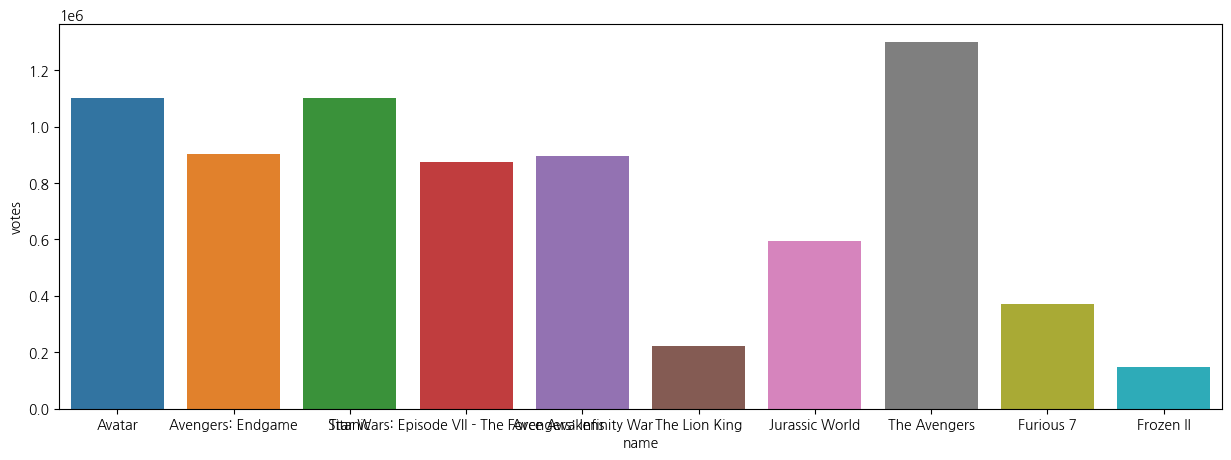

In [153]:
plt.figure(figsize=(15,5))
sns.barplot(x='name', y='votes', data=df.sort_values('gross', ascending=False).head(10))

### 연도별 gross, votes

In [157]:
df2 = df.loc[df.year.isin([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989])]
df2.gross.mean()

24177844.16568047

In [159]:
df2 = df.loc[df.year.isin([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])]
df2.gross.mean()

48326944.22943281

In [161]:
df2 = df.loc[df.year.isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009])]
df2.gross.mean()

92479471.43931796

In [163]:
df2 = df.loc[df.year.isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
df2.gross.mean()

134790587.6490964

Text(0.5, 1.0, 'month_2010s')

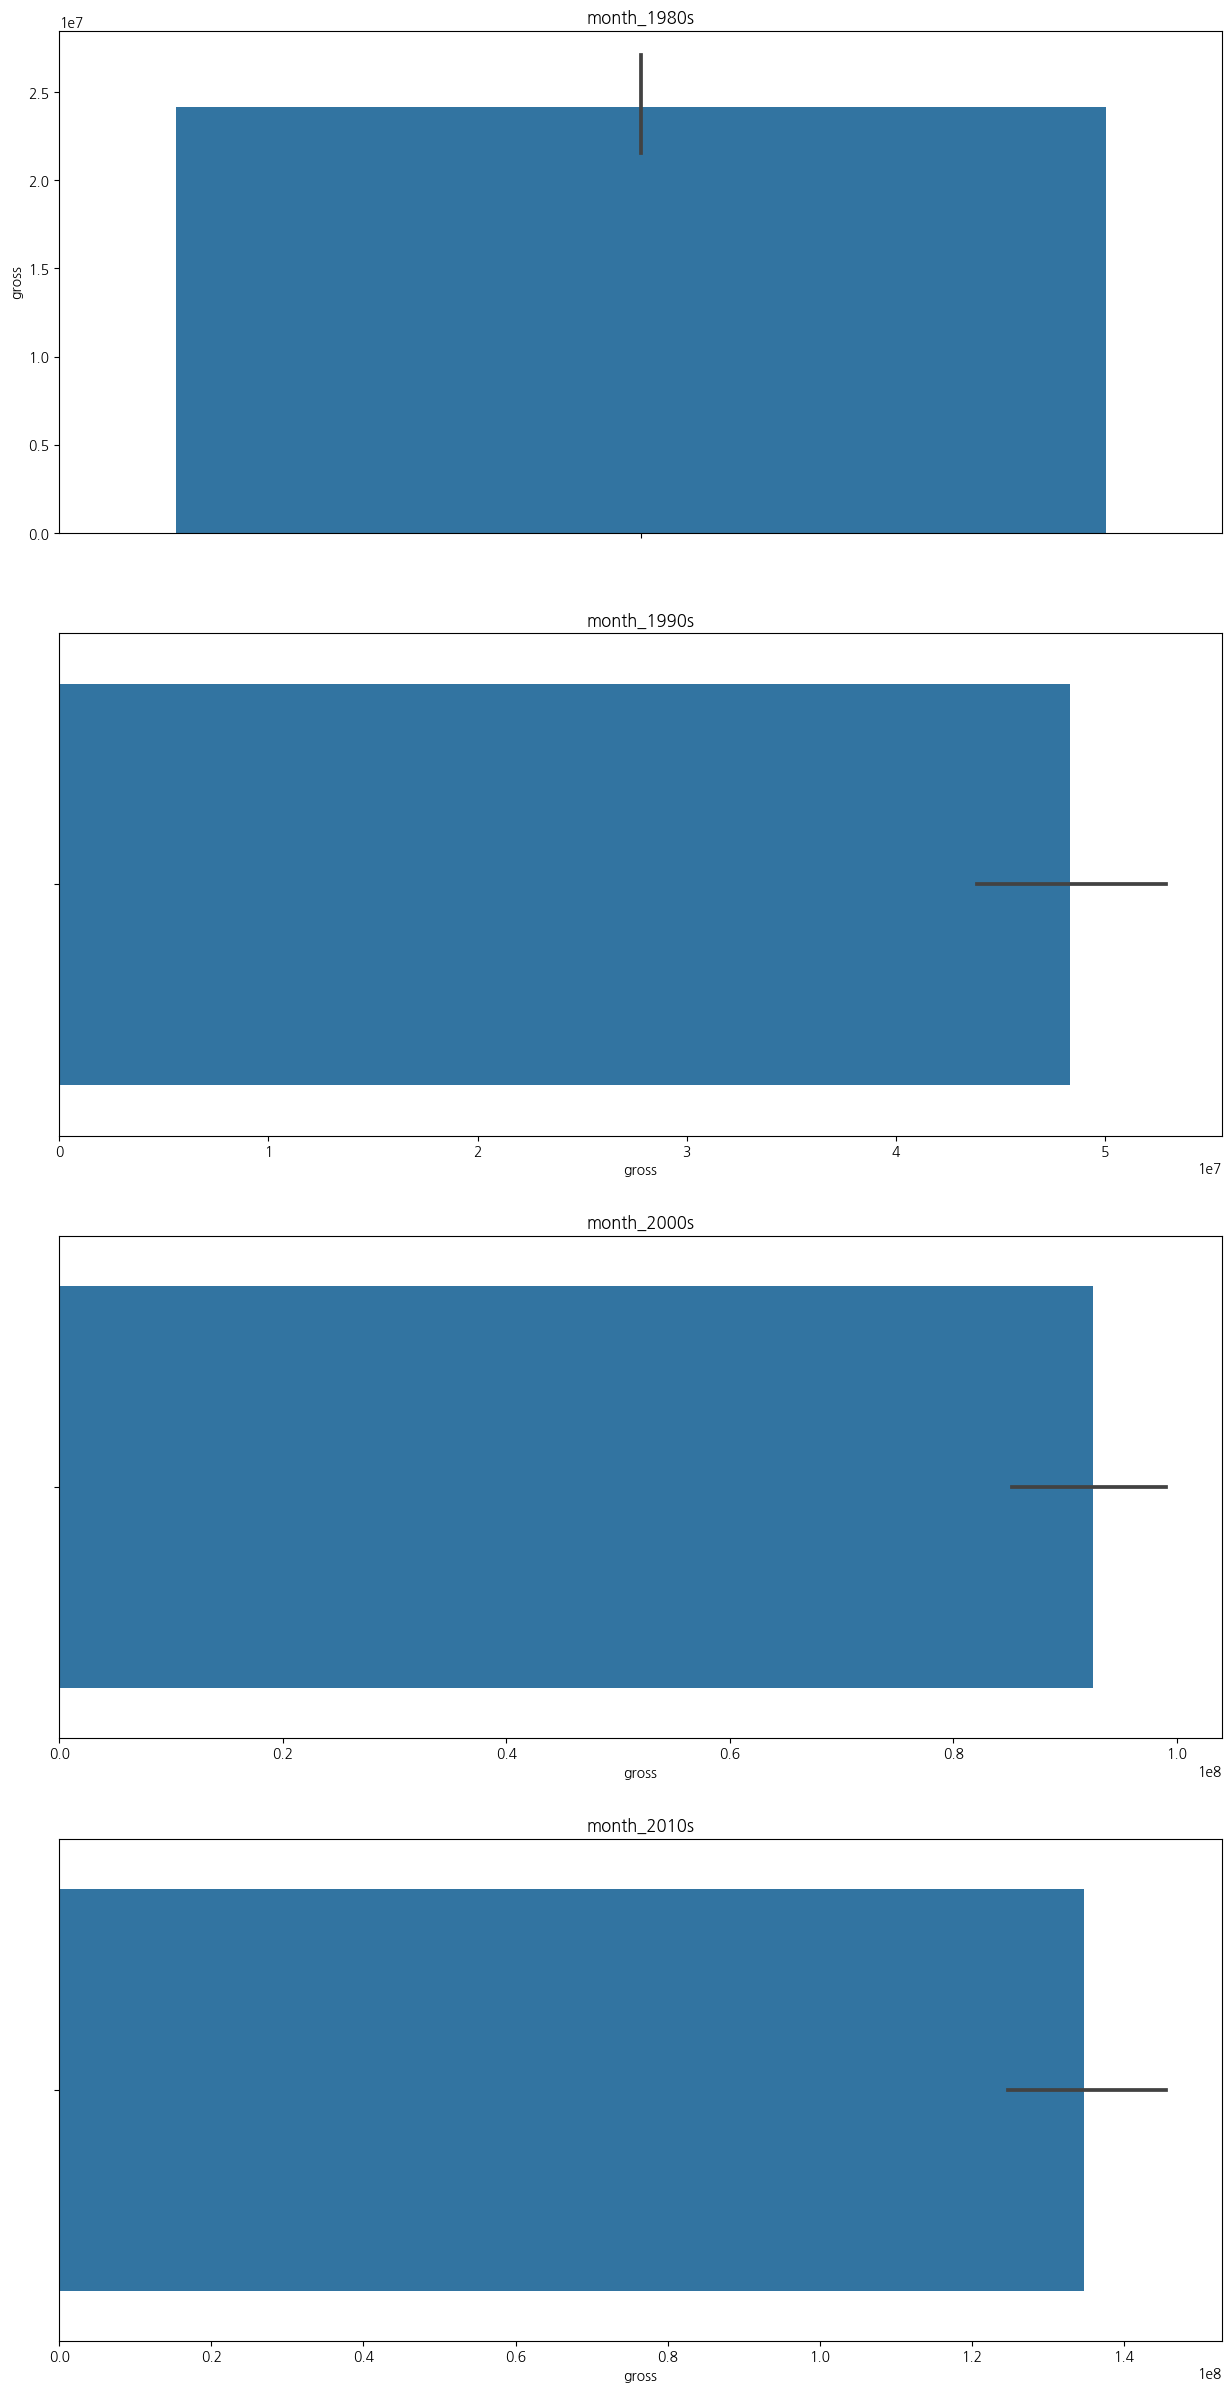

In [169]:
plt.figure(figsize=(15,30))
plt.subplot(4,1,1)
sns.barplot(y='gross', data=df.loc[df.year.isin([1980, 1981, 1982, 1983, 1984, 
                                                   1985, 1986, 1987, 1988, 1989])])
plt.title('month_1980s')

plt.subplot(4,1,2)
sns.barplot(x='gross', data=df.loc[df.year.isin([1990, 1991, 1992, 1993, 1994, 
                                                   1995, 1996, 1997, 1998, 1999])])
plt.title('month_1990s')

plt.subplot(4,1,3)
sns.barplot(x='gross', data=df.loc[df.year.isin([2000, 2001, 2002, 2003, 2004, 
                                                   2005, 2006, 2007, 2008, 2009])])
plt.title('month_2000s')

plt.subplot(4,1,4)
sns.barplot(x='gross', data=df.loc[df.year.isin([2010, 2011, 2012, 2013, 2014, 
                                                   2015, 2016, 2017, 2018, 2019])])
plt.title('month_2010s')